<a href="https://colab.research.google.com/github/DeepFluxion/IBMEC_Redes_Neurais_2026/blob/main/Notebooks/AC_2_Rede_Convolucional_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rede Neural Convolucional MNIST

## Etapa 1: Importação das bibliotecas

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
torch.__version__

'2.2.2'

## Etapa 2: Base de dados

In [ ]:
torch.manual_seed(123)

In [ ]:
transform = transforms.ToTensor()

In [ ]:
# Adicionando um espelho confiável
datasets.MNIST.mirrors = ["https://ossci-datasets.s3.amazonaws.com/mnist/"]


train = datasets.MNIST(root = '.', train = True, download=True, transform=transform)
test = datasets.MNIST(root = '.', train = False, download=True, transform=transform)

100%|████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:22<00:00, 444789.47it/s]


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw



100%|████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 164795.00it/s]


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:01<00:00, 1085363.79it/s]


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]


Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



In [ ]:
train.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [ ]:
train.data.shape

torch.Size([60000, 28, 28])

In [ ]:
28 * 28

784

In [ ]:
train.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [ ]:
train_loader = torch.utils.data.DataLoader(train, batch_size=128)
test_loader = torch.utils.data.DataLoader(test, batch_size=128)

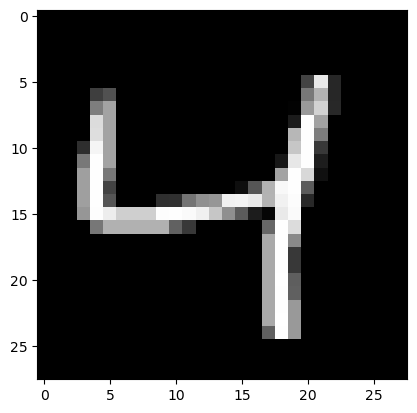

In [ ]:
imagem = next(iter(train_loader))[0][2].view(28, 28) # (1, 1, 28, 28)
plt.imshow(imagem, cmap='gray')

In [ ]:
imagem.shape

torch.Size([28, 28])

(array([669.,  10.,   7.,   9.,   8.,   5.,  27.,   5.,   8.,  36.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

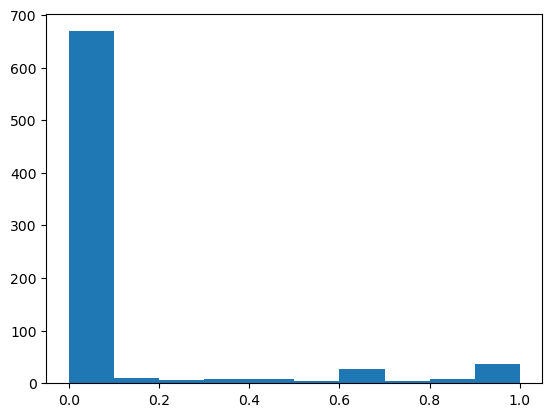

In [ ]:
plt.hist(imagem.view(-1))

## Etapa 3: Construção do modelo

In [ ]:
class classificador(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3))
        self.conv2 = nn.Conv2d(32, 32, (3, 3))
        self.activation = nn.ReLU()
        self.bnorm = nn.BatchNorm2d(num_features=32)
        self.pool = nn.MaxPool2d(kernel_size = (2,2))
        self.flatten = nn.Flatten()

        # output = (input - filter + 1) / stride
        # convolução 1: (28 - 3 + 1) / 1 = 26x26
        # pooling 1: 13x13
        # convolução 2: (13 - 3 + 1) / 1 = 11x11
        # pooling 2: 5x5
        # 5 * 5 * 32
        # 800 -> 128 -> 128 -> 10
        self.linear1 = nn.Linear(in_features=32*5*5, out_features=128)
        self.linear2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p = 0.2)

    def forward(self, X):
        X = self.pool(self.bnorm(self.activation(self.conv1(X))))
        X = self.pool(self.bnorm(self.activation(self.conv2(X))))
        X = self.flatten(X)

        X = self.dropout(self.activation(self.linear1(X)))
        X = self.dropout(self.activation(self.linear2(X)))
        X = self.output(X)
        return X

In [ ]:
net = classificador()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

## Etapa 4: Treinamento do modelo

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available else torch.devide('cpu')
device = 'cpu'

In [ ]:
net.to(device)

classificador(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=800, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.

    for i, data in enumerate(loader):
        inputs, labels = data

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        ps = F.softmax(outputs)
        top_p, top_class = ps.topk(k = 1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)

        accuracy = torch.mean(equals.type(torch.float))

        running_accuracy += accuracy


        # Imprimindo os dados referentes a este loop
        print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}'.format(epoch + 1, i + 1, len(loader), loss,
                                   accuracy), end = '\r')

    # Imprimindo os dados referentes a esta época
    print('\rÉPOCA {:3d} FINALIZADA: perda {:.5f} - precisão {:.5f}'.format(epoch+1, running_loss/len(loader),
                     running_accuracy/len(loader)))

In [ ]:
for epoch in range(5):
    print('Treinando...')
    training_loop(train_loader, epoch)
    net.eval()
    print('Validando...')
    training_loop(test_loader, epoch)
    net.train()

Treinando...


C:\Users\domin\AppData\Local\Temp\ipykernel_18964\896890224.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ps = F.softmax(outputs)


ÉPOCA   1 FINALIZADA: perda 0.15974 - precisão 0.953959
Validando...
ÉPOCA   1 FINALIZADA: perda 0.14194 - precisão 0.956780
Treinando...
ÉPOCA   2 FINALIZADA: perda 0.05290 - precisão 0.984629
Validando...
ÉPOCA   2 FINALIZADA: perda 0.06946 - precisão 0.980720
Treinando...
ÉPOCA   3 FINALIZADA: perda 0.03891 - precisão 0.988659
Validando...
ÉPOCA   3 FINALIZADA: perda 0.04412 - precisão 0.987640
Treinando...
ÉPOCA   4 FINALIZADA: perda 0.03041 - precisão 0.990639
Validando...
ÉPOCA   4 FINALIZADA: perda 0.03334 - precisão 0.990210
Treinando...
ÉPOCA   5 FINALIZADA: perda 0.02396 - precisão 0.992639
Validando...
ÉPOCA   5 FINALIZADA: perda 0.02494 - precisão 0.992780


## Etapa 5: Avaliação do modelo

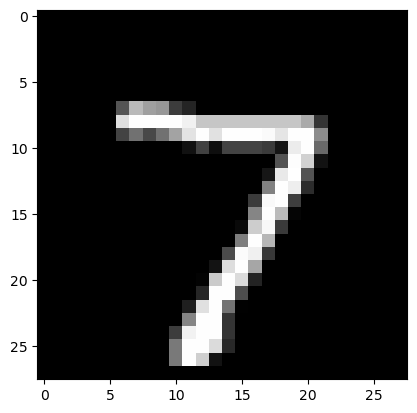

In [ ]:
imagem = next(iter(test_loader))[0][0].view(28,28)
plt.imshow(imagem, cmap='gray')

In [ ]:
# (1, 1, 28, 28) - (batch_size, número de canais, altura largura)
imagem.shape

torch.Size([28, 28])

In [ ]:
imagem = imagem.view(1, 1, 28, 28)
imagem.shape

torch.Size([1, 1, 28, 28])

In [ ]:
net.eval()
imagem = imagem.to(device)

In [ ]:
previsao = net.forward(imagem)

In [ ]:
previsao

tensor([[-5.1187e+00, -1.8336e+00, -1.4475e+00, -3.0895e+00, -1.3471e+00,
         -5.3044e+00, -9.0326e+00,  1.0334e+01, -3.6473e+00,  8.2807e-03]],
       grad_fn=<AddmmBackward0>)

In [ ]:
previsao = F.softmax(previsao)

C:\Users\domin\AppData\Local\Temp\ipykernel_18964\2146906489.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  previsao = F.softmax(previsao)


In [ ]:
previsao

tensor([[1.9444e-07, 5.1943e-06, 7.6416e-06, 1.4794e-06, 8.4484e-06, 1.6150e-07,
         3.8816e-09, 9.9994e-01, 8.4688e-07, 3.2766e-05]],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
previsao = previsao.cpu().detach().numpy()

In [ ]:
previsao

array([[1.9444158e-07, 5.1943075e-06, 7.6416200e-06, 1.4794078e-06,
        8.4484018e-06, 1.6149963e-07, 3.8815524e-09, 9.9994326e-01,
        8.4688224e-07, 3.2766289e-05]], dtype=float32)

In [ ]:
resultado = np.argmax(previsao)

In [ ]:
resultado

7

In [ ]:
def avaliar_acuracia(modelo, loader):
    # Coloca o modelo em modo de avaliação (desativa Dropout e Batch Normalization)
    modelo.eval()

    corretos = 0
    total = 0

    # Desativa o cálculo de gradientes para poupar memória e processamento
    with torch.no_grad():
        for imagens, labels in loader:
            # Move os dados para o mesmo dispositivo da rede (CPU ou GPU)
            imagens, labels = imagens.to(device), labels.to(device)

            # Forward pass
            outputs = modelo(imagens)

            # Pega o índice da classe com maior valor (o número previsto)
            _, previsoes = torch.max(outputs.data, 1)

            # Contabiliza o total de imagens e quantas a rede acertou
            total += labels.size(0)
            corretos += (previsoes == labels).sum().item()

    acuracia = 100 * corretos / total
    print(f'Acurácia final no dataset de teste: {acuracia:.2f}%')
    return acuracia

# Executa a avaliação usando as variáveis do seu notebook
avaliar_acuracia(net, test_loader)

Acurácia final no dataset de teste: 99.75%


99.75

### Tarefa 1: Impacto do Tamanho do Filtro (Kernel Size) - Valor 2 pontos

* **Objetivo**: Observar como o tamanho do kernel afeta a extração de características e o custo computacional.
* **O que alterar**: Na **Etapa 3**, dentro de `class classificador(nn.Module)`, mude o `kernel_size` de `(3,3)` para `(5,5)` em `self.conv1` e `self.conv2`.
* **Desafio**: Você precisará recalcular o `in_features` da camada `self.linear1`. Com kernel 5x5, a dimensão final antes do flatten será `4x4`, logo o novo valor será `32*4*4` em vez de `32*5*5`.
* **Avaliação**: Compare a acurácia final e o tempo de processamento por época.

### Tarefa 2: Comparação de Otimizadores - Valor 2 pontos

* **Objetivo**: Entender como diferentes algoritmos de otimização convergem para o erro mínimo.
* **O que alterar**: Abaixo da definição da classe, mude a linha `optimizer = optim.Adam(net.parameters())` para `optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)`.
* **Avaliação**: Observe se a perda (*loss*) diminui mais rápido ou mais devagar do que com o Adam e se a precisão final é atingida no mesmo número de épocas.

### Tarefa 3: Complexidade da Rede Densa (Camadas Ocultas) - Valor 2 pontos

* **Objetivo**: Analisar se aumentar a profundidade da parte "clássica" da rede melhora o desempenho.
* **O que alterar**: Na **Etapa 3**, altere a estrutura de `self.linear1` e `self.linear2`. Tente remover a `linear2` (e sua aplicação no `forward`) ou aumentar o número de neurônios de `128` para `256`.
* **Avaliação**: Verifique se adicionar mais neurônios causa **overfitting** (quando a precisão de treino é muito alta, mas a de validação estagna ou cai).

### Tarefa 4: O Papel da Regularização (Dropout) - Valor 2 pontos

* **Objetivo**: Estudar como o Dropout ajuda a prevenir o overfitting forçando a rede a aprender representações redundantes.
* **O que alterar**: Na **Etapa 3**, mude o valor de `p` em `self.dropout = nn.Dropout(p = 0.2)` para `0.0` (desativado) e depois para `0.5`.
* **Avaliação**: Use o script de acurácia final para ver em qual cenário a diferença entre o erro de treino e o de teste é menor.

### Tarefa 5: Profundidade Convolucional e Pooling - Valor 2 pontos

* **Objetivo**: Entender como camadas extras de convolução capturam padrões mais complexos.
* **O que alterar**: Adicione uma terceira camada convolucional (`self.conv3`) e uma respectiva normalização e ativação no `__init__` e no `forward`.
* **Desafio**: O aluno deve notar que cada camada de pooling reduz a imagem pela metade. Se adicionar mais um pooling, a imagem ficará pequena demais para a lógica atual, exigindo ajustes cuidadosos no fluxo dos dados.
* **Avaliação**: A rede com 3 camadas convolucionais é superior a de 2 camadas para um dataset simples como o MNIST?

---

**Dica**: Sempre que alterarem a arquitetura (Tarefas 1, 3 ou 5), lembrem-se de reinicializar o modelo executando a célula `net = classificador()` para que os pesos sejam resetados antes de um novo treinamento.

# Apresnet aqui seus resultados

### Tarefa 1: Impacto do Tamanho do Filtro (Kernel Size) - Valor 2 pontos

* **Suas conclusões abaixo**:

### Tarefa 2: Comparação de Otimizadores - Valor 2 pontos

* **Suas conclusões abaixo**:

### Tarefa 3: Complexidade da Rede Densa (Camadas Ocultas) - Valor 2 pontos

* **Suas conclusões abaixo**:

### Tarefa 4: O Papel da Regularização (Dropout) - Valor 2 pontos

* **Suas conclusões abaixo**:

### Tarefa 5: Profundidade Convolucional e Pooling - Valor 2 pontos

* **Suas conclusões abaixo**:


# Usando o tensorflow

In [ ]:
#! pip install tensorflow tensorflow-datasets scikit-learn matplotlib numpy packaging

In [ ]:
import sys

assert sys.version_info >= (3, 7)

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [ ]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [ ]:
# Este notebook está rodando no Colab ou no Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.


# Camadas Convolucionais
## Implementando Camadas Convolucionais com Keras

Vamos carregar duas imagens de exemplo, reescalar os valores dos pixels para 0-1 e recortá-las ao centro em imagens pequenas de 70×120:

In [ ]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [ ]:
images.shape

TensorShape([2, 70, 120, 3])

In [ ]:
tf.random.set_seed(42)  # código extra – garante reprodutibilidade
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [ ]:
fmaps.shape

TensorShape([2, 64, 114, 32])

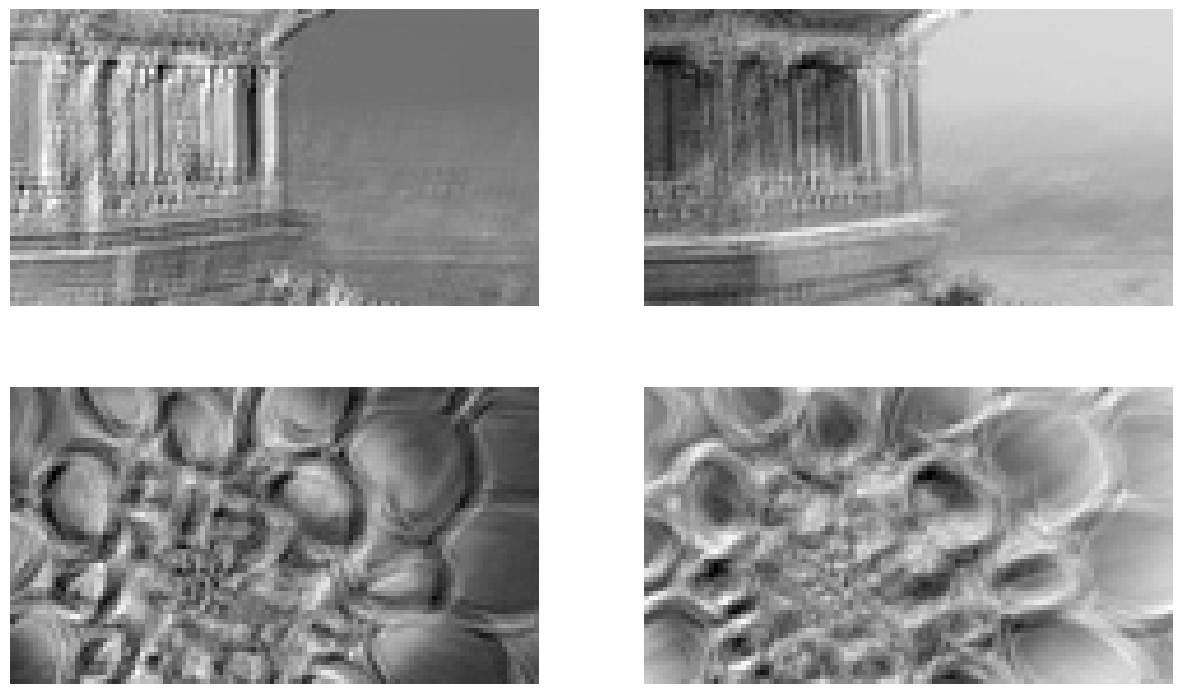

In [ ]:
# código extra – exibe os dois mapas de características de saída para cada imagem

plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

Como podemos ver, filtros gerados aleatoriamente geralmente atuam como detectores de bordas, o que é ótimo pois é uma ferramenta útil no processamento de imagens — e esse é o tipo de filtro com que uma camada convolucional normalmente começa. Durante o treinamento, ela aprende filtros cada vez melhores para reconhecer padrões úteis para a tarefa.

Agora vamos usar zero-padding:

In [ ]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [ ]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [ ]:
# código extra – mostra o shape da saída ao definir strides=2
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [ ]:
# código extra – esta função utilitária é útil para calcular o tamanho dos
#              mapas de características de saída de uma camada convolucional. Também retorna
#              o número de linhas/colunas ignoradas se padding="valid", ou
#              o número de linhas/colunas com zero-padding se padding="same"."""

import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

Vamos dar uma olhada nos pesos:

In [ ]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [ ]:
biases.shape

(32,)

In [ ]:
# código extra – mostra como usar a operação tf.nn.conv2d()

tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

Vamos criar manualmente dois filtros cheios de zeros, exceto por uma linha vertical de 1s no primeiro filtro e uma linha horizontal de 1s no segundo:

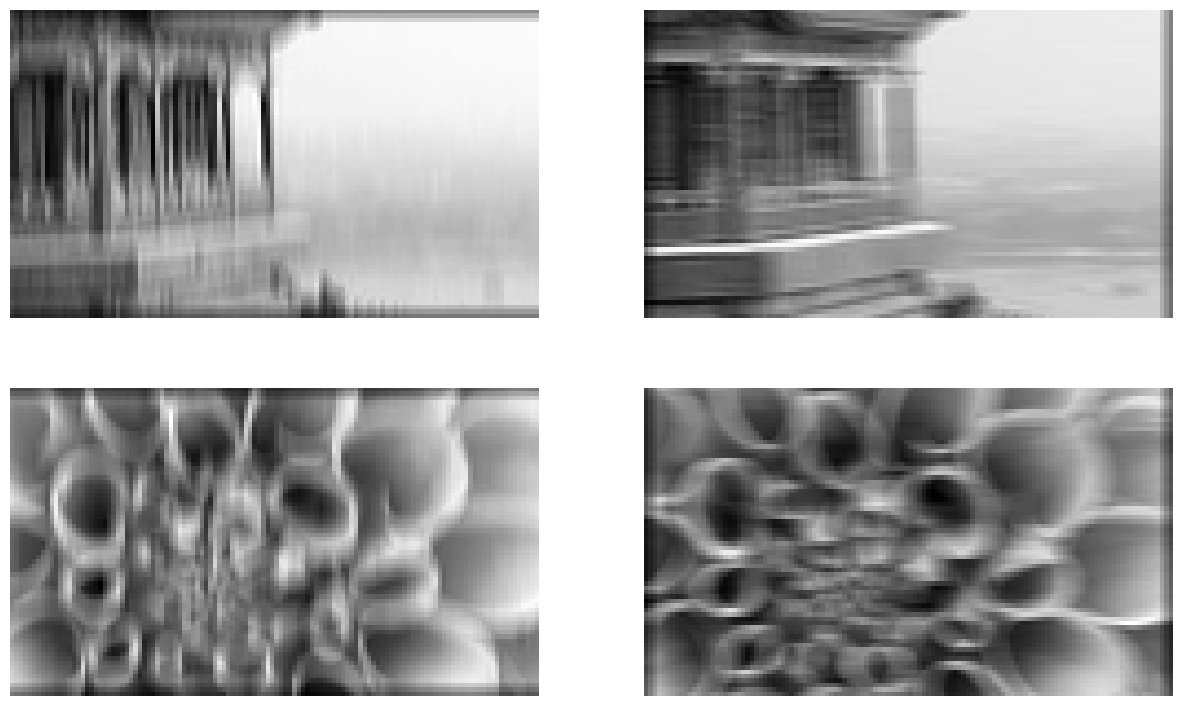

In [ ]:
# código extra – mostra como criar manualmente dois filtros para obter imagens similares
#              às da Figura 14–5.

plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

# Camadas de Pooling
## Implementando Camadas de Pooling com Keras

**Max pooling**

In [ ]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [ ]:
output = max_pool(images)

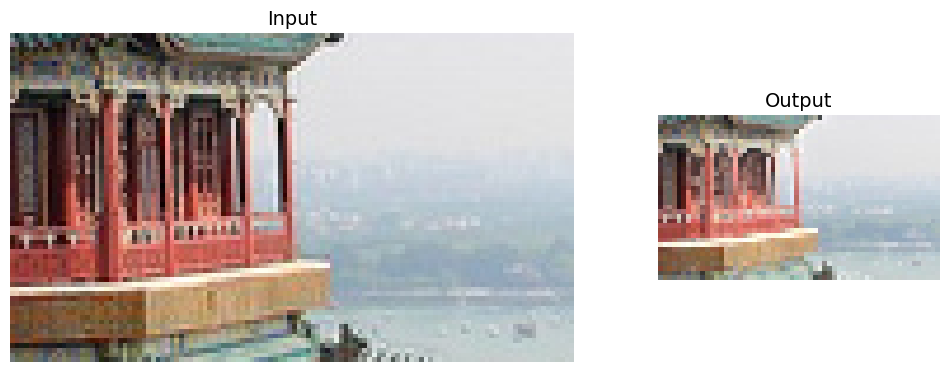

In [ ]:
# código extra – esta célula mostra como o max pooling com stride=2 se parece

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plota a 1ª imagem
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plota a saída da 1ª imagem
ax2.axis("off")
plt.show()